**Initialization**
* I use these 3 lines of code on top of my each Notebooks because it will help to prevent any problems while reloading and reworking on a Project or Problem. And the third line of code helps to make visualization within the Notebook.

In [1]:
#@ Initialization: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading the Libraries and Dependencies**

In [11]:
#@ Downloading the Libraries and Dependencies:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
from IPython.display import display

# try:
#   !pip uninstall tb-nightly tensorboardX tenosrboard
#   !pip install tf-nightly
# except Exception:
#   pass 

import tensorflow as tf
import os
import datetime
import tensorflow_datasets as tfds

from keras.models import Sequential                                              # Base Keras Neural Network Model.
from keras.layers import Dense, Bidirectional, LSTM, Dropout, Embedding          # Keras Functional API.
from keras.layers import Flatten

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
#@ Downloading the Libraries and Dependencies:
import pkg_resources
for entry_point in pkg_resources.iter_entry_points("tensorboard_plugins"):
  print(entry_point.dist)

tensorboard 2.3.0
tensorboard-plugin-wit 1.7.0


In [13]:
#@ Uninstalling the Tensorboard Colab:
# !rm -r /usr/local/lib/python3.6/dist-packages/tensorboardcolab-0.0.22.dist-info

**Getting the Data**
* I have used Google Colab for this Project so the process of downloading and reading the Data might be different in other platforms. I will use **Amazon Reviews Mobile Electronics Dataset** for this Project and I will import the Dataset using Tensorflow. The Dataset is already present in Tensorflow Dataset Library Corpus.

In [14]:
#@ Getting the Dataset:
dataset, info = tfds.load("amazon_us_reviews/Mobile_Electronics_v1_00", with_info=True)
train_dataset = dataset["train"]

#@ Inspecting the Information of the Dataset:
display(info)

#@ Inspecting the Dataset:
display(train_dataset)
display(len(list(train_dataset)))

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteIDSRQG/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

<DatasetV1Adapter shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>

104975

**Processing the Dataset**

In [15]:
#@ Parameters for Training the Dataset:
BUFFER_SIZE = 30000                       # Maximum number of elements that will be buffered when Prefetching.
BATCH_SIZE = 128                          # Number of samples fed into the Network.

#@ Processing the Dataset:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)  # Shuffling the Dataset.

#@ Inspecting the Dataset using Tensorflow:
for reviews in train_dataset.take(10):
  review_text = reviews["data"]                                                     # "data" is the key of Dataset.
  print(review_text.get("review_body").numpy())                                     # Converting the Tensors into Numpy arrays.
  print(review_text.get("star_rating"))                                             # Inspecting the Ratings.
  print(tf.where(review_text.get("star_rating")>3,1,0).numpy())                     # Rating greater than 3 is 1 and else 0.

b'Beautiful!'
tf.Tensor(5, shape=(), dtype=int32)
1
b"I bought this item for my husband because he has an Ipod touch! He doesn't use the computer and I was constantly having to charge it on my computer for him. Now he can charge it in his truck. Awesome!! Works Great!"
tf.Tensor(5, shape=(), dtype=int32)
1
b"I love this product so much I bought one for my boyfriend.  We both swim and the other swim mp3's we had always malfunctioned, came off during flip turns or just died after a few months.  I have had my shuffle for over a year now and it functions beautifully.  Several people in my gym have since purchased one after seeing mine.  This is also a nice product if you sweat a lot during workouts."
tf.Tensor(5, shape=(), dtype=int32)
1
b"Went from Waldorf, MD to Atlanta, GA and back on my motorcycle this week. I love this thing!  Strapped it to my handlebars, placed the IPOD in my pocket and rode.  I used it with my SENA SMH10 communication set and it worked wonderfully. But I am a havin

**Preprocessing the Model**
* Now, I will Tokenize the Data and convert it into Vocabulary. Vocabulary is the different combinations of words present inside the Model.

In [16]:
#@ Preprocessing the Model: Tokenization:
tokenizer = tfds.features.text.Tokenizer()                                         # Instantiating the Tokenizer.

vocabulary_set = set()                                                             # Removing the duplicates present in the Dataset.
for _, reviews in train_dataset.enumerate():
  review_text = reviews["data"]                                                    # "data" is the key of the Dataset.
  reviews_tokens = tokenizer.tokenize(review_text.get("review_body").numpy())      # Tokenizing the body of the Dataset.
  vocabulary_set.update(reviews_tokens)

#@ Inspecting the Vocabulary:
vocab_size = len(vocabulary_set)                                                   # Inspecting the length or size of Vocabulary.
vocab_size 

73738

* Now, I will encode the Vocabulary set into numerical values. I will implement the Text Encoder which basically takes all the Tokenized words and assign it to particular numerical values. 

In [17]:
#@ Preprocessing the Model: Encoding:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)                       # Encoding the Vocabulary set. 
   
for reviews in train_dataset.take(10):
  review_text = reviews["data"]                                                     # "data" is the key of the Dataset.
  print(review_text.get("review_body").numpy())
  encoded_example = encoder.encode(review_text.get("review_body").numpy())          # Encoding the Dataset.
  print(encoded_example)                                                            # Inspecting the Encoded Dataset.

b'Beautiful!'
[39670]
b"I bought this item for my husband because he has an Ipod touch! He doesn't use the computer and I was constantly having to charge it on my computer for him. Now he can charge it in his truck. Awesome!! Works Great!"
[49575, 20635, 4687, 22096, 11157, 60724, 18484, 46809, 824, 6228, 26505, 63424, 68135, 1444, 13757, 53819, 25417, 21339, 32630, 49450, 49575, 14580, 4272, 50287, 28149, 13345, 54221, 12241, 60724, 32630, 11157, 29739, 17139, 824, 55510, 13345, 54221, 26901, 45757, 72228, 15190, 67493, 70988]
b"I love this product so much I bought one for my boyfriend.  We both swim and the other swim mp3's we had always malfunctioned, came off during flip turns or just died after a few months.  I have had my shuffle for over a year now and it functions beautifully.  Several people in my gym have since purchased one after seeing mine.  This is also a nice product if you sweat a lot during workouts."
[49575, 58816, 4687, 51619, 29919, 48214, 49575, 20635, 43662, 11157

In [18]:
#@ Inspecting the Encoding:
for index in encoded_example:
  print("{} ----> {}".format(index, encoder.decode([index])))                  # Inspecting in one particular Example.

37425 ----> The
26469 ----> buttons
59836 ----> are
71405 ----> very
73438 ----> hard
28149 ----> to
2696 ----> press


**Preprocessing the Model**
* Now, I will Encode all the Dataset.

In [19]:
#@ Preprocessing the Model:
def encode(text_tensor, label_tensor):
  encoded_text = encoder.encode(text_tensor.numpy())        
  label = tf.where(label_tensor > 3,1,0)
  return encoded_text, label

def encode_map_fn(tensor):
  text = tensor["data"].get("review_body")                        # Accessing the review body from Tensor.
  label = tensor["data"].get("star_rating")                        # Accessing the ratings from Tensor.
  encoded_text, label = tf.py_function(encode,
                                       inp=[text, label],
                                       Tout=(tf.int64, tf.int32))
  encoded_text.set_shape([None])                                   # Automatically takes the shape.
  label.set_shape([])                                              # Automatically takes the shape.
  return encoded_text, label

#@ Encoding the Dataset:
encoded_data = train_dataset.map(encode_map_fn)                    # Encoding all the Dataset.

#@ Inspecting the Encoded Dataset:
for f0, f1 in encoded_data.take(3):
  print(f0)                                                        # Encoded text review.
  print(f1)                                                        # Encoded label.

tf.Tensor([39670], shape=(1,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(
[49575 20635  4687 22096 11157 60724 18484 46809   824  6228 26505 63424
 68135  1444 13757 53819 25417 21339 32630 49450 49575 14580  4272 50287
 28149 13345 54221 12241 60724 32630 11157 29739 17139   824 55510 13345
 54221 26901 45757 72228 15190 67493 70988], shape=(43,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(
[49575 58816  4687 51619 29919 48214 49575 20635 43662 11157 60724 67043
 73705  3679 13474 49450 21339 11193 13474 62080   593 21492  8606  3542
 60534 57772 57748 45697 13605 71484 28024 69095 45453 23042 25812 40566
 39382 49575 63018  8606 60724 62700 11157 46302 25812 49798 40999 49450
 54221 43826 61931 66019 22264 26901 60724 20516 63018 36567 47666 43662
 23042 38227 35924 14883 19062 57790 25812 33025 51619 20624  3097 20886
 25812 43102 45697  9280], shape=(76,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)


**Splitting the Dataset**
* Now, The Text Dataset is Tokenized and Encoded into particular Integers and it's readily available for Training the Model. So, I will split the Dataset into Training set and Testing or Validation set. I will split 10000 Encoded Dataset for Testing and the remaining Encoded Dataset for Training the Model. I will also perform padding to the Dataset to make the Data of constant length. 

In [20]:
#@ Splitting the Dataset:
TAKE_SIZE = 10000

#@ Training Dataset:
train_data = encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)           # Skipping the 10000 Encoded Dataset. 
train_data = train_data.padded_batch(BATCH_SIZE)                         # Padding the Dataset for constant length.

#@ Testing or Validation Dataset:
test_data = encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)                           # Padding the Dataset for constant length.

#@ Inspecting the Test Data:
sample_text, sample_label = next(iter(test_data))
sample_text[0], sample_label[0]                                          # Inspecting the Test Data.

(<tf.Tensor: shape=(620,), dtype=int64, numpy=
 array([39670,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

In [21]:
#@ Inspecting the Distribution of Positive and Negative Reviews:
for f0, f1 in test_data.take(10):
  print(tf.unique_with_counts(f1)[2].numpy())

[91 37]
[86 42]
[80 48]
[41 87]
[85 43]
[78 50]
[45 83]
[86 42]
[80 48]
[85 43]


* The Distribution of positive and negative sentiment reviews are not equal.

**Long Short Term Memory**
* Long Short Term Memory or LSTM is an Artificial Recurrent Neural Network or RNN architecture used in the field of Deep Learning. Unlike standard Feedforward Neural Networks, LSTM has Feedback connections. It can not only process single data points, but also entire sequences of data such as Speech or Video. Now, The Dataset is ready to build the Neural Network.

In [22]:
#@ Long Short Term Memory or LSTM:
vocab_size = vocab_size + 1                                   # Increasing the vocab size by 1.

model = Sequential()                                          # Standard Model Definition for Keras.
model.add(Embedding(                                          # Adding the Embedding Layer.
    vocab_size, 128     
))
model.add(Bidirectional(LSTM(                                 # Adding the Bidirectional LSTM Layer.
    128, return_sequences=True
)))
# model.add(Bidirectional(LSTM(                               # Adding another LSTM Layer.
#     64, return_sequences=True
# )))
model.add(Bidirectional(LSTM(                                 # Adding the third LSTM Layer.
    64, return_sequences=False
)))
model.add(Dense(                                              # Adding the Dense Layer
    64, activation="relu"
))
model.add(Dense(                                              # Adding another Dense Layer.
    64, activation="relu"
))
model.add(Dropout(0.2))                                       # Adding the Dropout layer.
model.add(Flatten())
model.add(Dense(1))                                           # Output Layer.

#@ Inspecting the Summary of the Model:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         9438592   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [23]:
# #@ Processing the Model:
# !rm -r /tmp/logs/                                                                     # Cleaning the tmp logs.

logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))   # Creating the log directory.
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)         # Captures the progress of the Model.
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/sentiment.hdf5", verbose=1, save_best_only=True                      # Saves only the best Model.
)

#@ Compiling the LSTM Neural Network:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

#@ Training the LSTM Neural Network:
history = model.fit(
    train_data, epochs=3,
    validation_data=test_data,
    callbacks=[tensorboard_callback, checkpointer]
)

Epoch 1/3
742/742 [==============================] - 7884s 11s/step - loss: 0.4209 - accuracy: 0.7853 - val_loss: 0.2801 - val_accuracy: 0.8755

Epoch 00001: val_loss improved from inf to 0.28013, saving model to /tmp/sentiment.hdf5
Epoch 2/3
742/742 [==============================] - 7593s 10s/step - loss: 0.2367 - accuracy: 0.9036 - val_loss: 0.2709 - val_accuracy: 0.8856

Epoch 00002: val_loss improved from 0.28013 to 0.27091, saving model to /tmp/sentiment.hdf5
Epoch 3/3
742/742 [==============================] - 7513s 10s/step - loss: 0.1859 - accuracy: 0.9294 - val_loss: 0.3116 - val_accuracy: 0.8734

Epoch 00003: val_loss did not improve from 0.27091


**Model Evaluation**

In [24]:
#@ Saving the Model:
model.save("/tmp/final_sentiment.hdf5")

#@ Evaluating the Model:
eval_loss, eval_accuracy = model.evaluate(test_data)
print("\nEval loss:{:.3f}, Eval accuracy:{:.3f}".format(eval_loss, eval_accuracy))

79/79 [==============================] - 237s 3s/step - loss: 0.3116 - accuracy: 0.8734

Eval loss:0.312, Eval accuracy:0.873


In [25]:
#@ Inspecting the Sentiment of Test Data:
for f0, f1 in test_data.take(1):
  print(f1)
  print(model.predict(f0))

tf.Tensor(
[1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0
 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1], shape=(128,), dtype=int32)
[[ 4.7829175 ]
 [ 4.306049  ]
 [ 5.353168  ]
 [-0.19685489]
 [ 4.93677   ]
 [ 4.3705907 ]
 [-3.635945  ]
 [-0.84840083]
 [ 4.580627  ]
 [-3.25108   ]
 [ 4.861857  ]
 [ 4.927709  ]
 [ 5.089006  ]
 [ 4.5485616 ]
 [-4.432257  ]
 [ 2.4489863 ]
 [ 6.8845534 ]
 [-5.395208  ]
 [ 2.367188  ]
 [ 5.4765    ]
 [ 5.204985  ]
 [-1.6892974 ]
 [ 5.871961  ]
 [ 5.344337  ]
 [ 5.5941415 ]
 [ 5.87442   ]
 [-4.101936  ]
 [ 4.7475996 ]
 [ 4.7322598 ]
 [ 3.0994918 ]
 [ 6.6228075 ]
 [ 1.3830044 ]
 [ 3.3174105 ]
 [ 4.7126474 ]
 [-4.7337384 ]
 [ 4.313247  ]
 [ 3.55868   ]
 [ 6.426739  ]
 [ 5.2906895 ]
 [ 3.149171  ]
 [-3.5058782 ]
 [ 2.4892862 ]
 [ 1.5045129 ]
 [ 4.239735  ]
 [-4.2222376 ]
 [-2.098059  ]
 [-2.26023

In [33]:
#@ Function for Data Visualization:
import matplotlib.pyplot as plt                             # Module for Data Visualization.

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history["val_" +metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, "val_"+metric])
  plt.show()

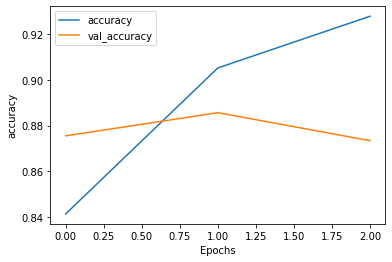

In [34]:
#@ Visualizing the accuracy:
plot_graphs(history, "accuracy")

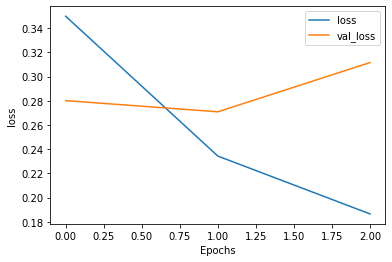

In [35]:
#@ Visualizing the loss:
plot_graphs(history, "loss")

* Now, I will use the Model to predict the Sentiment of the actual Text Data and I will load the best model to predict the Sentiment of that Data.

In [37]:
#@ Model Evaluation:
best_model = tf.keras.models.load_model("/tmp/sentiment.hdf5", compile=False)

#@ Padding the Input Text Data:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

#@ Predicting the Sentiment of the Text Data:
def predict_fn(pred_text):
  encoded_pred_text = encoder.encode(pred_text)
  print(encoded_pred_text)
  encoded_pred_text = pad_to_size(encoded_pred_text, 32)
  print(encoded_pred_text)
  encoded_pred_text = tf.cast(encoded_pred_text, tf.float32)
  predictions = best_model.predict(tf.expand_dims(encoded_pred_text, 0))
  return (predictions)

#@ Example of the Text Data:
pred_text = "The package was good looking but the product is quite annoying. I think I should change it soon."
predictions = predict_fn(pred_text)
print(predictions)

[37425, 42608, 14580, 64528, 52588, 54321, 21339, 51619, 19062, 27766, 56937, 49575, 43026, 49575, 70082, 67696, 54221, 44347]
[37425, 42608, 14580, 64528, 52588, 54321, 21339, 51619, 19062, 27766, 56937, 49575, 43026, 49575, 70082, 67696, 54221, 44347, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-1.3544923]]


In [39]:
#@ Inspection:
# %reload_ext tensorboard
# %tensorboard --logdir /tmp/logs